In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
import skfuzzy as fuzz
from scipy.ndimage import binary_erosion, binary_dilation
from scipy.spatial.distance import directed_hausdorff
from tqdm import tqdm

In [11]:
base_path = r"C:\sem-6\DLMI_assignments\data\train"

img_dir  = os.path.join(base_path, "original")
mask_dir = os.path.join(base_path, "mask")

image_files = sorted(os.listdir(img_dir))
print(f"Found {len(image_files)} images in dataset")

Found 1169 images in dataset


In [12]:
# Helper functions for segmentation
def extract_boundary(mask):
    eroded = binary_erosion(mask)
    boundary = mask.astype(bool) & ~eroded
    return boundary.astype(np.uint8)

def hausdorff_distance(mask1, mask2):
    pts1 = np.argwhere(mask1)
    pts2 = np.argwhere(mask2)
    if len(pts1)==0 or len(pts2)==0:
        return float('inf')
    d1 = directed_hausdorff(pts1, pts2)[0]
    d2 = directed_hausdorff(pts2, pts1)[0]
    return max(d1,d2)

def boundary_f1_score(pred_boundary, gt_boundary, tolerance=2):
    struct = np.ones((2*tolerance+1, 2*tolerance+1))
    gt_dilated   = binary_dilation(gt_boundary,structure=struct)
    pred_dilated = binary_dilation(pred_boundary,structure=struct)

    tp_pred = np.sum(pred_boundary & gt_dilated)
    tp_gt   = np.sum(gt_boundary & pred_dilated)

    precision = tp_pred/(np.sum(pred_boundary)+1e-8)
    recall    = tp_gt/(np.sum(gt_boundary)+1e-8)
    f1 = 2*precision*recall/(precision+recall+1e-8)

    return precision, recall, f1

In [13]:
# Initialize metric storage
metrics_kmeans = {'iou': [], 'hausdorff': [], 'precision': [], 'recall': [], 'f1': []}
metrics_fcm = {'iou': [], 'hausdorff': [], 'precision': [], 'recall': [], 'f1': []}

k = 3  # Number of clusters

# Process all images with progress bar
for img_name in tqdm(image_files, desc="Processing images"):
    # Load image and mask
    img_path = os.path.join(img_dir, img_name)
    mask_name = os.path.splitext(img_name)[0] + '.png'
    mask_path = os.path.join(mask_dir, mask_name)
    
    # Check if mask exists
    if not os.path.exists(mask_path):
        continue
    
    # Read and preprocess
    img = cv2.imread(img_path)
    gt_mask = cv2.imread(mask_path, 0)
    
    img = cv2.resize(img, (256, 256))
    gt_mask = cv2.resize(gt_mask, (256, 256))
    gt_mask = (gt_mask > 127).astype(np.uint8)
    
    # K-Means segmentation
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    pixels = lab.reshape((-1, 3)).astype(np.float32)
    
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels_kmeans = kmeans.fit_predict(pixels)
    
    seg_kmeans = labels_kmeans.reshape(256, 256)
    centers = kmeans.cluster_centers_
    
    nucleus_cluster = np.argmin(centers[:, 0])
    nucleus_mask_kmeans = (seg_kmeans == nucleus_cluster).astype(np.uint8)
    
    # FCM segmentation
    data = pixels.T
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data, c=k, m=2, error=0.005, maxiter=1000
    )
    
    nucleus_cluster_fcm = np.argmin(cntr[:, 0])
    membership = u[nucleus_cluster_fcm].reshape(256, 256)
    nucleus_mask_fcm = (membership > 0.5).astype(np.uint8)
    
    # Calculate IoU
    gt_flat = gt_mask.flatten()
    km_flat = nucleus_mask_kmeans.flatten()
    fcm_flat = nucleus_mask_fcm.flatten()
    
    iou_kmeans = jaccard_score(gt_flat, km_flat)
    iou_fcm = jaccard_score(gt_flat, fcm_flat)
    
    # Extract boundaries
    gt_boundary = extract_boundary(gt_mask)
    km_boundary = extract_boundary(nucleus_mask_kmeans)
    fcm_boundary = extract_boundary(nucleus_mask_fcm)
    
    # Calculate Hausdorff distance
    hd_kmeans = hausdorff_distance(km_boundary, gt_boundary)
    hd_fcm = hausdorff_distance(fcm_boundary, gt_boundary)
    
    # Calculate boundary metrics
    prec_km, rec_km, f1_km = boundary_f1_score(km_boundary, gt_boundary)
    prec_fcm, rec_fcm, f1_fcm = boundary_f1_score(fcm_boundary, gt_boundary)
    
    # Store metrics
    metrics_kmeans['iou'].append(iou_kmeans)
    metrics_kmeans['hausdorff'].append(hd_kmeans)
    metrics_kmeans['precision'].append(prec_km)
    metrics_kmeans['recall'].append(rec_km)
    metrics_kmeans['f1'].append(f1_km)
    
    metrics_fcm['iou'].append(iou_fcm)
    metrics_fcm['hausdorff'].append(hd_fcm)
    metrics_fcm['precision'].append(prec_fcm)
    metrics_fcm['recall'].append(rec_fcm)
    metrics_fcm['f1'].append(f1_fcm)

print(f"\n✓ Processed {len(metrics_kmeans['iou'])} images successfully")

Processing images: 100%|██████████| 1169/1169 [44:06<00:00,  2.26s/it] 


✓ Processed 1169 images successfully


In [14]:
# Calculate average metrics
avg_kmeans = {key: np.mean(values) for key, values in metrics_kmeans.items()}
avg_fcm = {key: np.mean(values) for key, values in metrics_fcm.items()}

# Display results
print("\n" + "="*60)
print(f"DATASET-WIDE COMPARISON ({len(metrics_kmeans['iou'])} images)")
print("="*60)
print(f"{'Metric':<30} {'K-Means':>12} {'FCM':>12}")
print("-"*60)
print(f"{'IoU Score':<30} {avg_kmeans['iou']:>12.4f} {avg_fcm['iou']:>12.4f}")
print(f"{'Hausdorff Distance (px)':<30} {avg_kmeans['hausdorff']:>12.4f} {avg_fcm['hausdorff']:>12.4f}")
print(f"{'Boundary Precision':<30} {avg_kmeans['precision']:>12.4f} {avg_fcm['precision']:>12.4f}")
print(f"{'Boundary Recall':<30} {avg_kmeans['recall']:>12.4f} {avg_fcm['recall']:>12.4f}")
print(f"{'Boundary F1-Score':<30} {avg_kmeans['f1']:>12.4f} {avg_fcm['f1']:>12.4f}")
print("="*60)


DATASET-WIDE COMPARISON (1169 images)
Metric                              K-Means          FCM
------------------------------------------------------------
IoU Score                            0.6029       0.5829
Hausdorff Distance (px)             35.8121      35.0500
Boundary Precision                   0.7784       0.7712
Boundary Recall                      0.8802       0.8737
Boundary F1-Score                    0.8180       0.8134


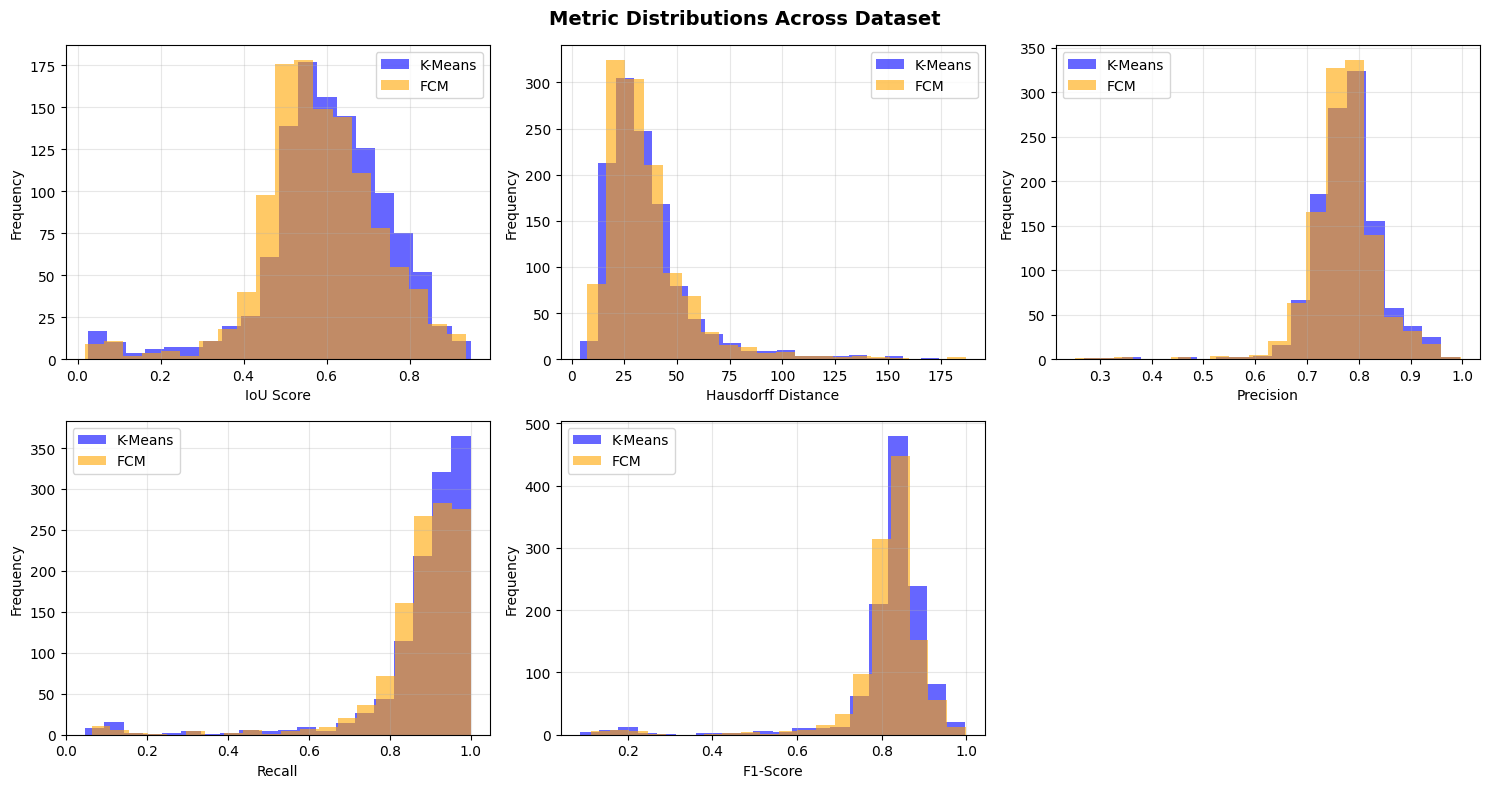

In [15]:
# Visualize metric distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Metric Distributions Across Dataset', fontsize=14, fontweight='bold')

metrics_to_plot = ['iou', 'hausdorff', 'precision', 'recall', 'f1']
titles = ['IoU Score', 'Hausdorff Distance', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    ax.hist(metrics_kmeans[metric], alpha=0.6, bins=20, label='K-Means', color='blue')
    ax.hist(metrics_fcm[metric], alpha=0.6, bins=20, label='FCM', color='orange')
    ax.set_xlabel(title)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(alpha=0.3)

# Hide the last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

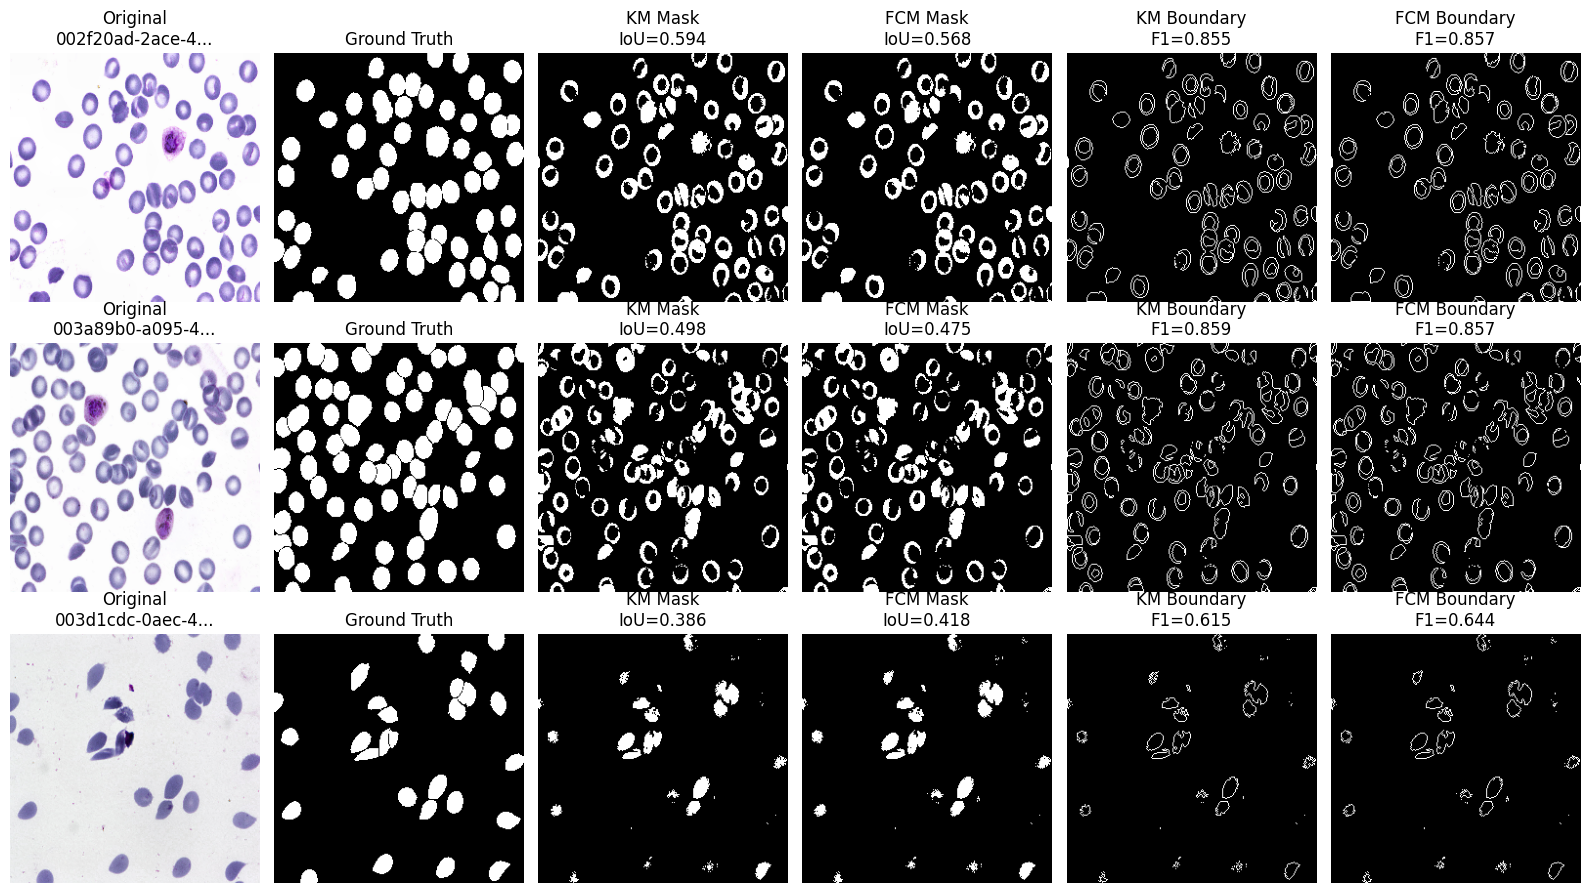

In [16]:
# Visualize a few sample results
num_samples = min(3, len(image_files))
fig, axes = plt.subplots(num_samples, 6, figsize=(16, num_samples*3))

if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    img_name = image_files[i]
    img_path = os.path.join(img_dir, img_name)
    mask_name = os.path.splitext(img_name)[0] + '.png'
    mask_path = os.path.join(mask_dir, mask_name)
    
    # Load and process
    img = cv2.imread(img_path)
    gt_mask = cv2.imread(mask_path, 0)
    img = cv2.resize(img, (256, 256))
    gt_mask = cv2.resize(gt_mask, (256, 256))
    gt_mask = (gt_mask > 127).astype(np.uint8)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # K-Means
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    pixels = lab.reshape((-1, 3)).astype(np.float32)
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
    labels_kmeans = kmeans.fit_predict(pixels)
    seg_kmeans = labels_kmeans.reshape(256, 256)
    centers = kmeans.cluster_centers_
    nucleus_cluster = np.argmin(centers[:, 0])
    nucleus_mask_kmeans = (seg_kmeans == nucleus_cluster).astype(np.uint8)
    
    # FCM
    data = pixels.T
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data, c=3, m=2, error=0.005, maxiter=1000)
    nucleus_cluster_fcm = np.argmin(cntr[:, 0])
    membership = u[nucleus_cluster_fcm].reshape(256, 256)
    nucleus_mask_fcm = (membership > 0.5).astype(np.uint8)
    
    # Boundaries
    km_boundary = extract_boundary(nucleus_mask_kmeans)
    fcm_boundary = extract_boundary(nucleus_mask_fcm)
    
    # Plot
    axes[i, 0].imshow(img_rgb)
    axes[i, 0].set_title(f'Original\n{img_name[:15]}...')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(gt_mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(nucleus_mask_kmeans, cmap='gray')
    axes[i, 2].set_title(f'KM Mask\nIoU={metrics_kmeans["iou"][i]:.3f}')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(nucleus_mask_fcm, cmap='gray')
    axes[i, 3].set_title(f'FCM Mask\nIoU={metrics_fcm["iou"][i]:.3f}')
    axes[i, 3].axis('off')
    
    axes[i, 4].imshow(km_boundary, cmap='gray')
    axes[i, 4].set_title(f'KM Boundary\nF1={metrics_kmeans["f1"][i]:.3f}')
    axes[i, 4].axis('off')
    
    axes[i, 5].imshow(fcm_boundary, cmap='gray')
    axes[i, 5].set_title(f'FCM Boundary\nF1={metrics_fcm["f1"][i]:.3f}')
    axes[i, 5].axis('off')

plt.tight_layout()
plt.show()

In [17]:
# Statistical summary
print("\n" + "="*60)
print("STATISTICAL SUMMARY")
print("="*60)

for metric_name in ['iou', 'hausdorff', 'precision', 'recall', 'f1']:
    print(f"\n{metric_name.upper()}:")
    print(f"  K-Means  - Mean: {np.mean(metrics_kmeans[metric_name]):.4f}, "
          f"Std: {np.std(metrics_kmeans[metric_name]):.4f}, "
          f"Min: {np.min(metrics_kmeans[metric_name]):.4f}, "
          f"Max: {np.max(metrics_kmeans[metric_name]):.4f}")
    print(f"  FCM      - Mean: {np.mean(metrics_fcm[metric_name]):.4f}, "
          f"Std: {np.std(metrics_fcm[metric_name]):.4f}, "
          f"Min: {np.min(metrics_fcm[metric_name]):.4f}, "
          f"Max: {np.max(metrics_fcm[metric_name]):.4f}")


STATISTICAL SUMMARY

IOU:
  K-Means  - Mean: 0.6029, Std: 0.1544, Min: 0.0245, Max: 0.9475
  FCM      - Mean: 0.5829, Std: 0.1430, Min: 0.0179, Max: 0.9358

HAUSDORFF:
  K-Means  - Mean: 35.8121, Std: 21.0098, Min: 4.0000, Max: 174.0402
  FCM      - Mean: 35.0500, Std: 20.0663, Min: 7.2801, Max: 186.9438

PRECISION:
  K-Means  - Mean: 0.7784, Std: 0.0668, Min: 0.2700, Max: 0.9953
  FCM      - Mean: 0.7712, Std: 0.0653, Min: 0.2520, Max: 0.9970

RECALL:
  K-Means  - Mean: 0.8802, Std: 0.1539, Min: 0.0460, Max: 1.0000
  FCM      - Mean: 0.8737, Std: 0.1363, Min: 0.0623, Max: 1.0000

F1:
  K-Means  - Mean: 0.8180, Std: 0.1192, Min: 0.0870, Max: 0.9976
  FCM      - Mean: 0.8134, Std: 0.1051, Min: 0.1140, Max: 0.9985
